# **ABCDEats Inc. - Clustering Analysis: Cuisines and Spending Propensity**

# 1. Imports, Options and Ingestion

In [1]:
# Imports list
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import SparsePCA

from sklearn.mixture import GaussianMixture

In [2]:
# Style is importantuntitled:Untitled-1.ipynb?jupyter-notebook
sns.set(style="white")

# Ensuring pandas always prints all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 1000)

%config InlineBackend.figure_format = 'retina'

In [3]:
path = '../../data/'

In [4]:
# Reading the csv data
regulars = pd.read_csv(f'{path}regulars_preproc.csv', index_col=0)

# 2. Sparse PCA

In [5]:
log_cuisine_features = [
    'log_american', 'log_asian', 'log_beverages', 'log_cafe', 
    'log_chinese', 'log_desserts', 'log_healthy', 'log_indian',
    'log_italian', 'log_japanese', 'log_noodle_dishes', 'log_other',
    'log_street_food_snacks', 'log_thai', 'log_chicken_dishes'
]

log_features = [
    'log_total_amt', 'log_n_order',
    'log_avg_amt_per_product', 'log_avg_amt_per_order', 'log_chicken_dishes',
    'log_avg_amt_per_vendor', 'log_n_days_week', 'log_n_times_day',
    'avg_amt_per_day', 'avg_product_per_day', 'avg_order_per_day'
]

cuisine_factors = regulars[log_cuisine_features].copy()
n_components_spca = 2
n_components_gmm = 3

In [6]:
# Apply Sparse PCA to extract sparse components
sparse_pca = SparsePCA(n_components=n_components_spca, random_state=0)

# Fit the Sparse PCA model
sparse_pca.fit(cuisine_factors)

# Get the Sparse PCA components
components = sparse_pca.components_

# Get the top labels for Sparse PCA components (top values in each component)
top_labels = {}
for i, component in enumerate(components):
    sorted_indices = np.argsort(component)[::-1]  # Sort in descending order
    top_features = cuisine_factors.columns[sorted_indices][:3]  # Top 3 features
    top_labels[f'Component_{i+1}'] = top_features

# Display top labels for each Sparse PCA component
print("\nTop Labels for Each Sparse PCA Component:")
for component, labels in top_labels.items():
    print(f"{component}: {', '.join(labels)}")
    
# Convert the components into a DataFrame with cuisines as columns and components as rows
components_df = pd.DataFrame(components, columns=log_cuisine_features, index=[f"Component_{i+1}" for i in range(components.shape[0])])

# Display the DataFrame
print("\nSparse PCA Components DataFrame:")
display(components_df.T)


Top Labels for Each Sparse PCA Component:
Component_1: log_italian, log_other, log_thai
Component_2: log_noodle_dishes, log_chicken_dishes, log_chinese

Sparse PCA Components DataFrame:


,Component_1,Component_2
log_american,0.065739,-0.203794
log_asian,-0.386875,-0.223143
log_beverages,-0.312602,0.220078
log_cafe,0.265773,-0.107634
log_chinese,-0.057538,0.418952
log_desserts,-0.278973,0.011946
log_healthy,0.072438,-0.072801
log_indian,0.271280,0.022030
log_italian,0.437570,-0.219282
log_japanese,-0.000000,-0.052071


**Component 1:** 
- High contribution from Italian, Other, Thai, Indian and Cafe.
- Negative contribution from Asian, Beverages, Street Food and Snacks and Desserts.
- This may indicate a preference for dining diversity over simpler, snack-like foods.

**Component 2:**
- High contribution from Chinese, Noodle Dishes, Chicken Dishes, Other and Beverages.
- Negative contribution from American, Asian, Italian and Street Food and Snacks.
- This may indicate a contrast between comfort/chinese-style meals and western-style, lighter meals.

In [7]:
# Transform the original data using the fitted Sparse PCA model
transformed_data = sparse_pca.transform(cuisine_factors)

# Convert the transformed data into a DataFrame for better interpretability
# Each row corresponds to a sample, and columns are the Sparse PCA components
transformed_df = pd.DataFrame(
    transformed_data,
    columns=[f"Component_{i+1}" for i in range(n_components_spca)],
    index=cuisine_factors.index  # Keep the original indices for reference
)

# Display the transformed data
print("\nTransformed Data (Sparse PCA Scores):")
display(transformed_df.head())


Transformed Data (Sparse PCA Scores):


,Component_1,Component_2
customer_id,,
103287041752,0.273483,-0.478764
338018592517,-0.771969,-1.107885
459279132454,-0.810026,-0.602902
568914241263,-0.215339,-0.257756
1043496422503,-0.929598,0.182253


In [8]:
columns_to_add = ['log_total_amt', 'log_avg_amt_per_product']
additional_data = regulars[columns_to_add]  # Extract the desired columns

# Concatenate the transformed data with the additional columns
final_df = pd.concat([transformed_df, additional_data], axis=1)

# Display the result
print("\nFinal DataFrame after Concatenation:")
display(final_df.head())



Final DataFrame after Concatenation:


,Component_1,Component_2,log_total_amt,log_avg_amt_per_product
customer_id,,,,
103287041752,0.273483,-0.478764,0.044481,1.064285
338018592517,-0.771969,-1.107885,0.731668,1.172173
459279132454,-0.810026,-0.602902,-0.240428,1.413172
568914241263,-0.215339,-0.257756,-1.646540,-0.943028
1043496422503,-0.929598,0.182253,0.207882,1.341536


# 3. Gaussian Mixture Model

In [9]:
# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
gmm_labels = gmm.fit_predict(transformed_df)

# Add GMM labels to the DataFrame
transformed_df['cluster'] = gmm_labels

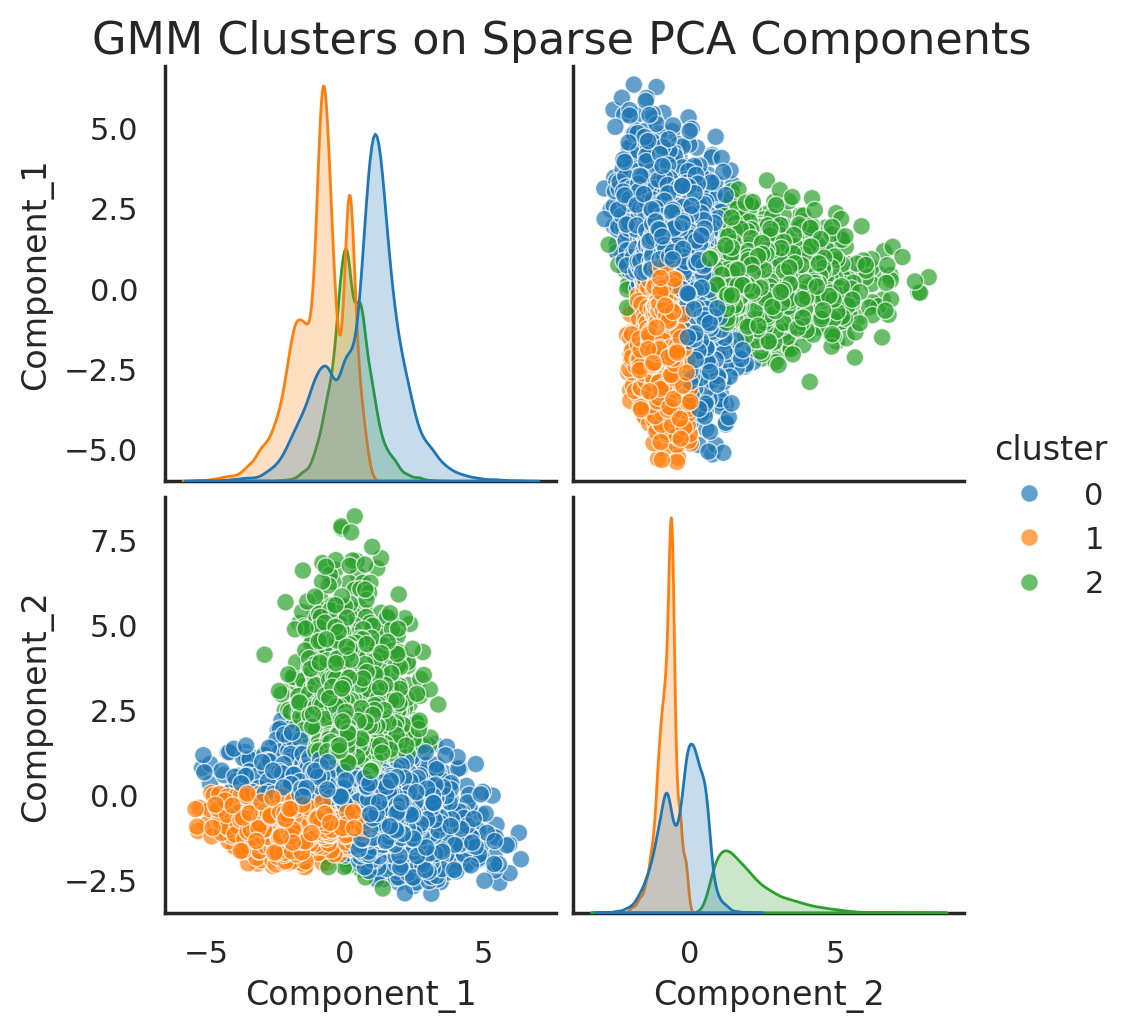

In [10]:
# Pairplot of GMM clusters
sns.pairplot(
    transformed_df,
    vars=[f"Component_{i+1}" for i in range(n_components_spca)],  # Select PCA components
    hue='cluster',
    palette='tab10',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 40}  # Adjust scatter plot transparency and size
)

# Add a title
plt.suptitle("GMM Clusters on Sparse PCA Components", y=1.02, fontsize=16)

# Show the plot
plt.show()

In [11]:
# Step 1: Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
gmm_labels = gmm.fit_predict(final_df)

# Add GMM labels to the DataFrame
final_df['cluster'] = gmm_labels

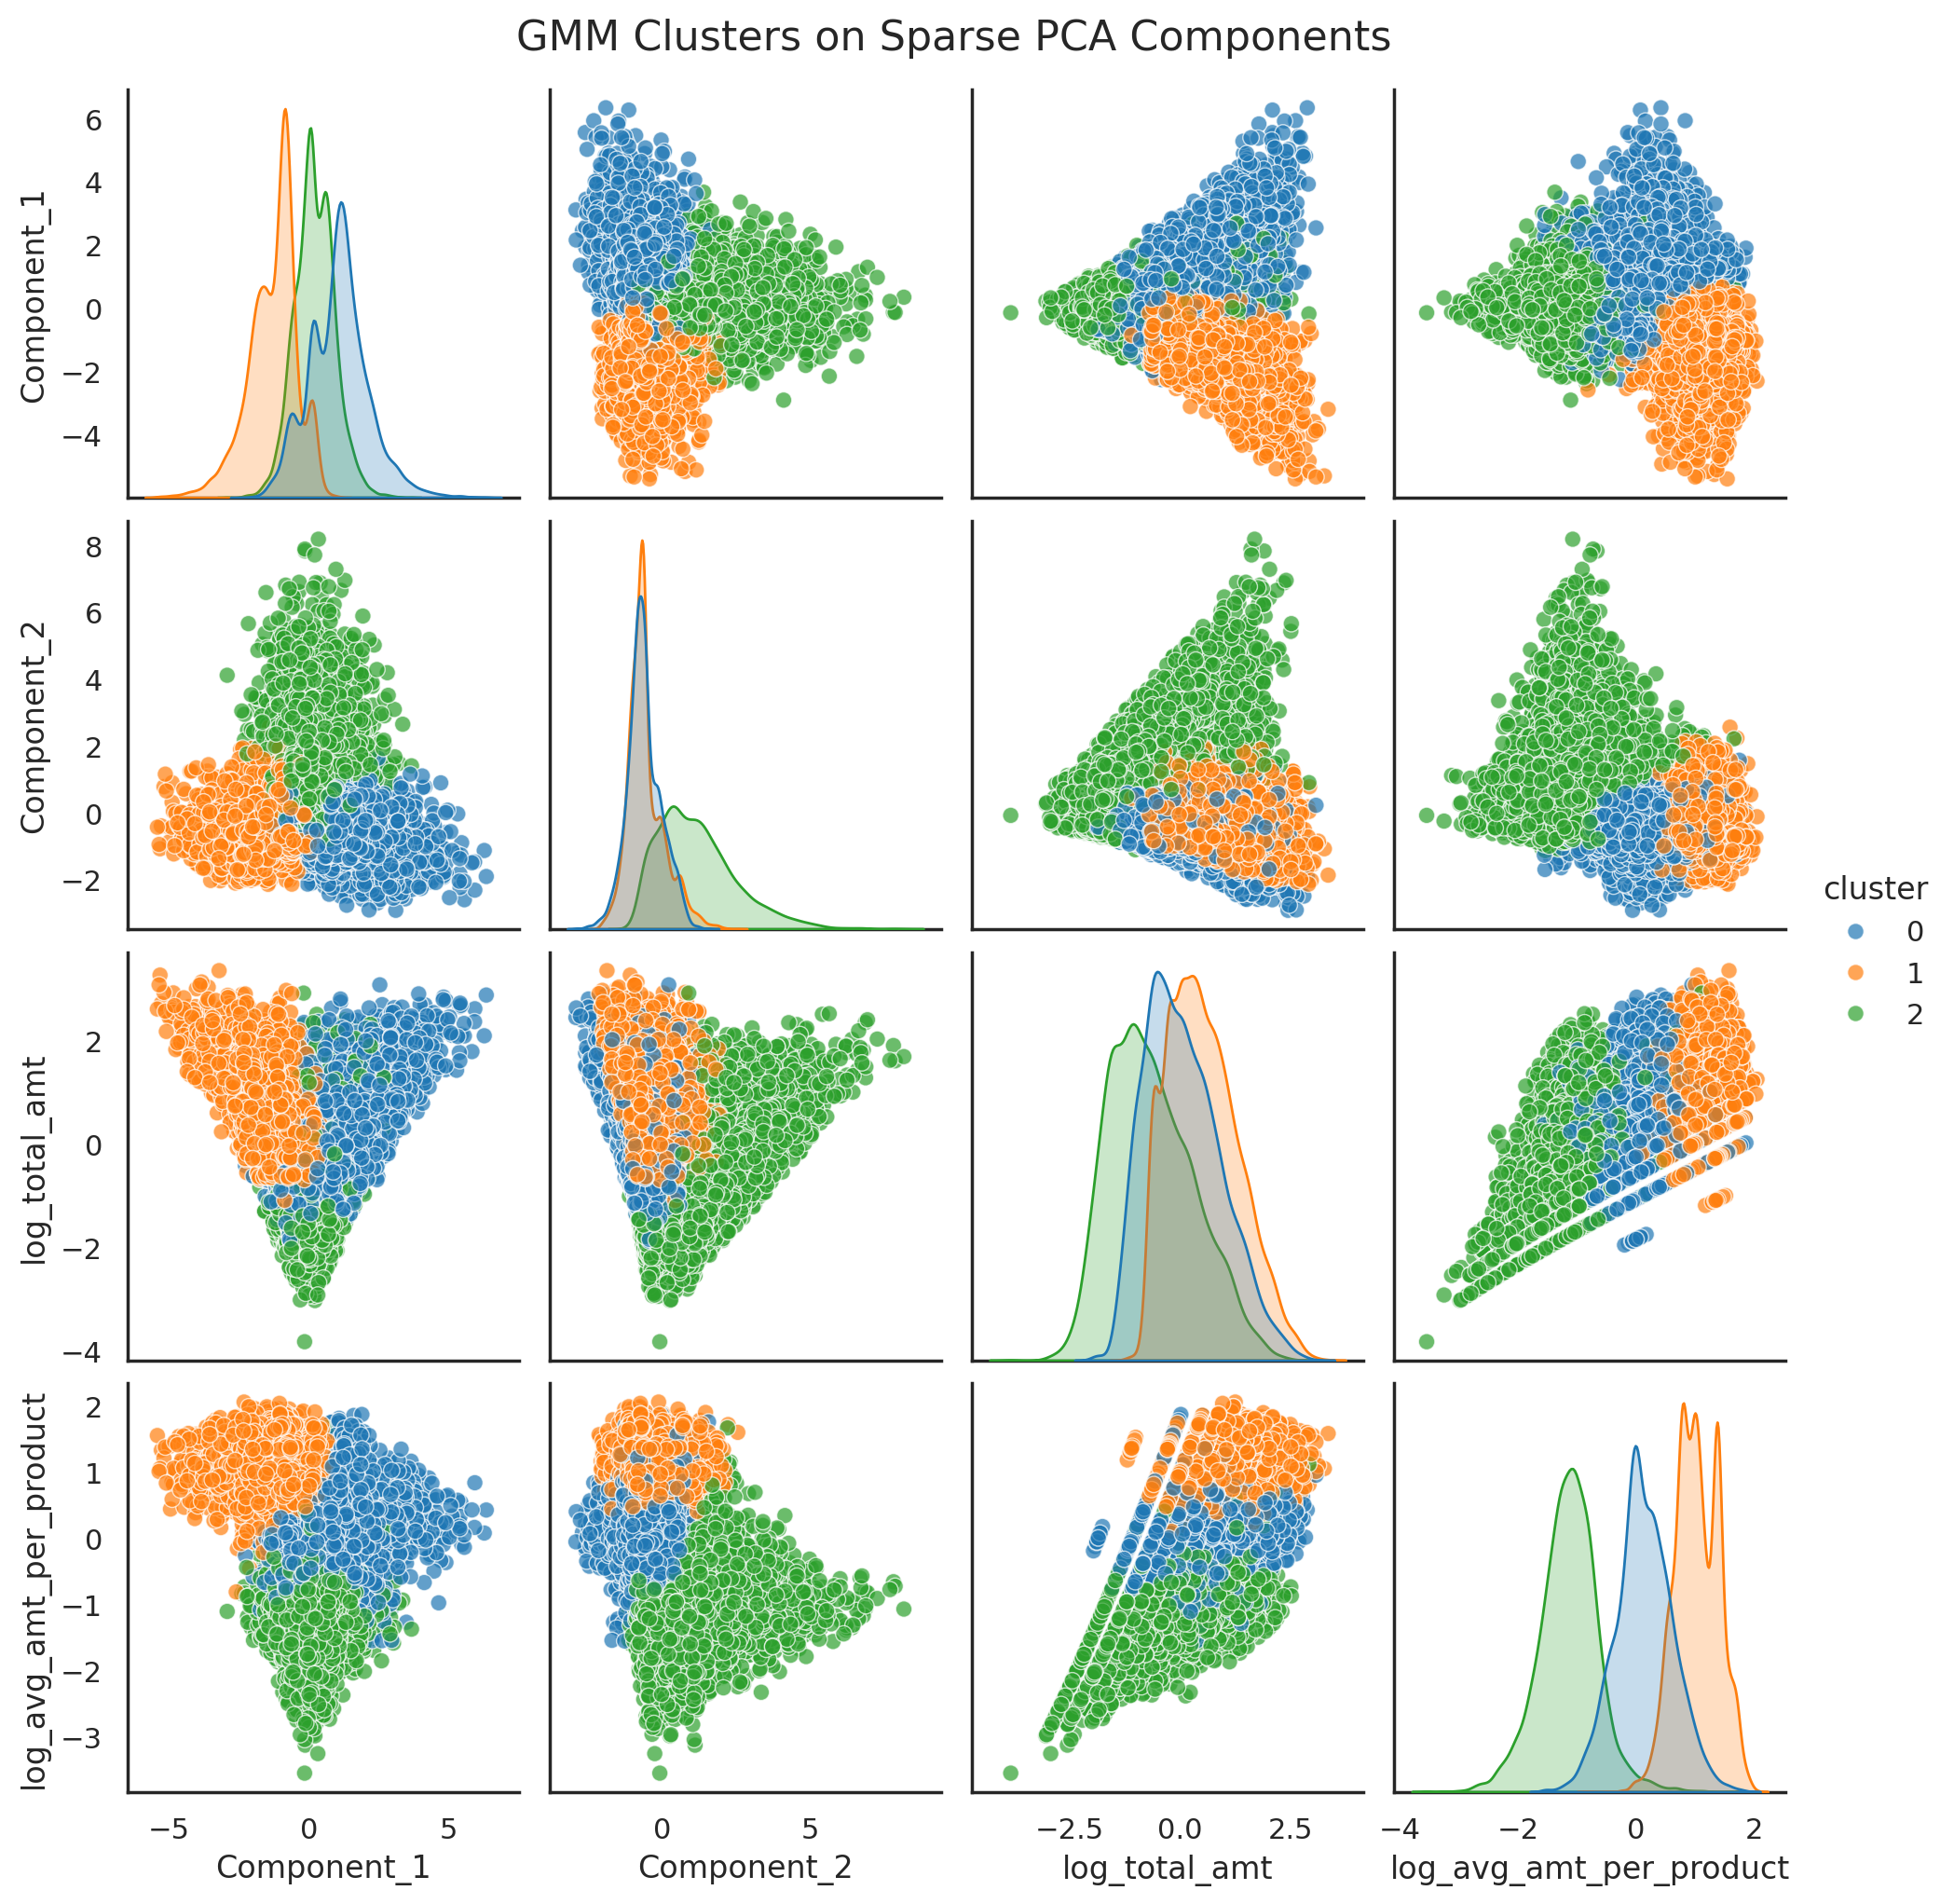

In [12]:
# Pairplot of GMM clusters
sns.pairplot(
    final_df,
    hue='cluster',
    palette='tab10',
    diag_kind='kde',
    plot_kws={'alpha': 0.7, 's': 40},
)

# Add a title
plt.suptitle("GMM Clusters on Sparse PCA Components", y=1.02, fontsize=16)

# Show the plot
plt.show()

In [13]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(final_df.drop(columns='cluster'))  # get total sum of squares
ssw_labels = final_df.groupby(by='cluster').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

/tmp/ipykernel_7201/1689455065.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ssw_labels = final_df.groupby(by='cluster').apply(get_ss)  # compute ssw for each cluster labels


0.5057338775190575